# A/B Testing Customizable Framework - Univariate

### A/B test Configuration

In [59]:
# Configuration: A/B Test Parameters
AB_TEST_CONFIG = {
    "file_path": 'ab_test_dataset.csv',
    "alpha": 0.05,  # Significance level
    "power": 0.8,   # Statistical power
    "confidence_interval": 0.95,  # Confidence interval
    "baseline_rate": 0.1,  # Expected baseline conversion rate
    "mde": 0.02,  # Minimum detectable effect (e.g., 2% increase)
    "n_samples": 1000,  # Total number of samples to generate (for synthetic data)
}

### Caluclate Reqired Sample Size:

In [60]:
# Pre-test assumptions using the configuration dictionary
def pre_test_summary(config):
    """
    Print a summary of pre-test assumptions and calculated sample size.
    """
    baseline_rate = config["baseline_rate"]
    mde = config["mde"]
    alpha = config["alpha"]
    power = config["power"]

    print(f"Pre-Test Planning Summary:")
    print(f"----------------------------------------")
    print(f"Baseline conversion rate: {baseline_rate * 100:.2f}%")
    print(f"Minimum detectable effect (MDE): {mde * 100:.2f}%")
    print(f"Significance level (alpha): {alpha}")
    print(f"Statistical power: {power}")
    print(f"----------------------------------------")
    
    required_size = calculate_required_sample_size(baseline_rate, mde, alpha, power)
    print(f"Required sample size per group: {required_size} samples")
    print(f"Total required sample size (Control + Variant): {2 * required_size} samples")
    print(f"Ensure that both groups have at least {required_size} participants to achieve the desired power.")

# Example usage:
if __name__ == "__main__":
    # Use the configuration dictionary
    pre_test_summary(AB_TEST_CONFIG)


Pre-Test Planning Summary:
----------------------------------------
Baseline conversion rate: 10.00%
Minimum detectable effect (MDE): 2.00%
Significance level (alpha): 0.05
Statistical power: 0.8
----------------------------------------
Required sample size per group: 3533 samples
Total required sample size (Control + Variant): 7066 samples
Ensure that both groups have at least 3533 participants to achieve the desired power.


### Run the A/B testing framowerk:

Loading data from ab_test_dataset.csv
Loaded 4600 records from CSV.
Cleaned data: 4600 records (removed 0 records due to missing values).
Using Welch's t-test (equal_var=False) for unequal variances.

Conversion Rates Summary:
         Conversions  Total      Rate
Group                                
Control          254   2600  0.097692
Variant          267   2000  0.133500

Required sample size per group for detecting the MDE: 3533 samples
Observed required sample size per group (based on observed effect size): 1081 samples
Sample size per group used: 2600 samples
⚠️ Sample size is insufficient for detecting the MDE.
✅ Sample size is also sufficient based on the observed effect size.

Post-hoc power of the test: 0.98
Absolute difference in rates (Variant - Control): 0.0358
Standardized effect size (Cohen's h): 0.1206
p-value: 0.0002 (statistically significant)

Confidence Intervals:
Control: (0.08627260588580983, 0.10911200949880555)
Variant: (0.11858134585013583, 0.1484186541498642

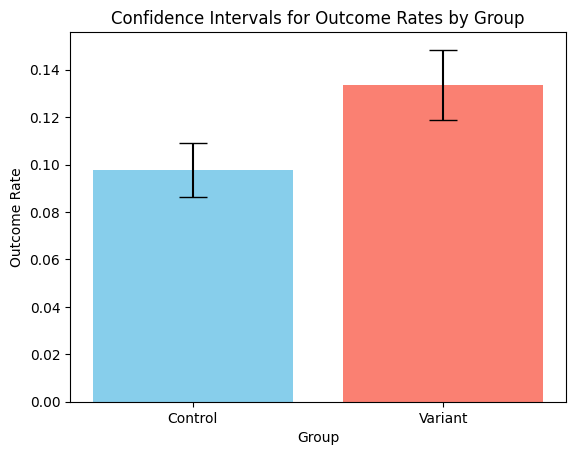

In [64]:
# Import libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
from statsmodels.stats.power import TTestIndPower

# Configuration: A/B Test Parameters
AB_TEST_CONFIG = {
    "file_path": 'ab_test_dataset.csv',
    "alpha": 0.05,  # Significance level
    "power": 0.8,   # Statistical power
    "confidence_interval": 0.95,  # Confidence interval
    "baseline_rate": 0.1,  # Expected baseline conversion rate
    "mde": 0.02,  # Minimum detectable effect (e.g., 2% increase)
    "n_samples": 1000,  # Total number of samples to generate (for synthetic data)
}

# Required columns in the dataset
REQUIRED_COLUMNS = {'Group', 'Outcome'}

# Load or generate synthetic data
def load_data(config):
    file_path = config["file_path"]
    n_samples = config["n_samples"]

    if not os.path.exists(file_path):
        print("No valid file path provided or file not found. Using synthetic dataset.")
        return generate_synthetic_data(n_samples)

    print(f"Loading data from {file_path}")
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} records from CSV.")

    if not REQUIRED_COLUMNS.issubset(df.columns):
        raise ValueError(f"Missing required columns: {REQUIRED_COLUMNS - set(df.columns)}")
    return df

# Generate synthetic data
def generate_synthetic_data(n_samples):
    np.random.seed(42)
    control_group = pd.DataFrame({
        'User ID': range(1, n_samples // 2 + 1),
        'Group': 'Control',
        'Outcome': np.random.choice([0, 1], size=n_samples // 2, p=[0.9, 0.1])
    })
    variant_group = pd.DataFrame({
        'User ID': range(n_samples // 2 + 1, n_samples + 1),
        'Group': 'Variant',
        'Outcome': np.random.choice([0, 1], size=n_samples // 2, p=[0.85, 0.15])
    })
    df = pd.concat([control_group, variant_group], ignore_index=True)
    print(f"Generated synthetic dataset with {len(df)} records.")
    return df

# Clean data
def clean_data(df):
    initial_count = len(df)
    df = df.dropna(subset=['Group', 'Outcome'])
    cleaned_count = len(df)
    print(f"Cleaned data: {cleaned_count} records (removed {initial_count - cleaned_count} records due to missing values).")
    return df.reset_index(drop=True)

# Calculate required sample size before the test
def calculate_required_sample_size(baseline_rate, mde, alpha, power):
    effect_size = mde / np.sqrt(baseline_rate * (1 - baseline_rate))
    required_size = TTestIndPower().solve_power(effect_size=effect_size, alpha=alpha, power=power)
    return int(np.ceil(required_size))

# Calculate observed required sample size
def calculate_observed_required_sample_size(observed_effect_size, alpha, power):
    observed_required_size = TTestIndPower().solve_power(effect_size=observed_effect_size, alpha=alpha, power=power)
    return int(np.ceil(observed_required_size))

# Perform A/B test
def perform_ab_test(df, alpha, power, use_welch=True):
    control = df[df['Group'] == 'Control']['Outcome']
    variant = df[df['Group'] == 'Variant']['Outcome']

    if use_welch:
        print("Using Welch's t-test (equal_var=False) for unequal variances.")
        t_stat, p_value = stats.ttest_ind(control, variant, equal_var=False)
    else:
        print("Using Student's t-test (equal_var=True) for equal variances.")
        t_stat, p_value = stats.ttest_ind(control, variant, equal_var=True)

    control_rate = control.mean()
    variant_rate = variant.mean()
    control_n = len(control)
    variant_n = len(variant)
    
    # Absolute difference in conversion rates
    absolute_difference = variant_rate - control_rate

    # Standardized effect size (Cohen's h)
    effect_size = absolute_difference / np.sqrt(control_rate * (1 - control_rate))

    # Calculate observed required sample size
    observed_required_size = calculate_observed_required_sample_size(effect_size, alpha, power)

    # Post-hoc power calculation
    post_hoc_power = TTestIndPower().power(effect_size=effect_size, nobs1=control_n, ratio=variant_n / control_n, alpha=alpha, alternative='two-sided')

    return {
        "t_statistic": t_stat,
        "p_value": p_value,
        "significant": p_value < alpha,
        "post_hoc_power": post_hoc_power,
        "cohen_h_effect_size": effect_size,
        "absolute_difference": absolute_difference,
        "control_rate": control_rate,
        "variant_rate": variant_rate,
        "sample_size_per_group": control_n,
        "observed_required_size": observed_required_size
    }

# Calculate confidence intervals
def calculate_confidence_intervals(df, confidence):
    intervals = {}
    for group, data in df.groupby('Group'):
        mean = data['Outcome'].mean()
        margin_error = stats.sem(data['Outcome']) * stats.t.ppf((1 + confidence) / 2, len(data) - 1)
        intervals[group] = (mean - margin_error, mean + margin_error)
    return intervals

# Plot confidence intervals
def plot_confidence_intervals(confidence_intervals):
    groups = list(confidence_intervals.keys())
    means = [(interval[0] + interval[1]) / 2 for interval in confidence_intervals.values()]
    errors = [(interval[1] - interval[0]) / 2 for interval in confidence_intervals.values()]
    plt.bar(groups, means, yerr=errors, capsize=10, color=['skyblue', 'salmon'])
    plt.title('Confidence Intervals for Outcome Rates by Group')
    plt.xlabel('Group')
    plt.ylabel('Outcome Rate')
    plt.show()

# Display results    
def display_results(conversion_summary, test_results, confidence_intervals, required_size):
    print("\nConversion Rates Summary:")
    print(conversion_summary)
    print(f"\nRequired sample size per group for detecting the MDE: {required_size} samples")
    print(f"Observed required sample size per group (based on observed effect size): {test_results['observed_required_size']} samples")
    print(f"Sample size per group used: {test_results['sample_size_per_group']} samples")

    # Interpretation
    if test_results['sample_size_per_group'] >= required_size:
        print("✅ Sample size is sufficient for detecting the MDE.")
    else:
        print("⚠️ Sample size is insufficient for detecting the MDE.")

    if test_results['sample_size_per_group'] >= test_results['observed_required_size']:
        print("✅ Sample size is also sufficient based on the observed effect size.")
    else:
        print("⚠️ Sample size is insufficient based on the observed effect size.")

    print(f"\nPost-hoc power of the test: {test_results['post_hoc_power']:.2f}")
    print(f"Absolute difference in rates (Variant - Control): {test_results['absolute_difference']:.4f}")
    print(f"Standardized effect size (Cohen's h): {test_results['cohen_h_effect_size']:.4f}")
    print(f"p-value: {test_results['p_value']:.4f} ({'statistically significant' if test_results['significant'] else 'not statistically significant'})")
    print("\nConfidence Intervals:")
    for group, interval in confidence_intervals.items():
        print(f"{group}: {interval}")
    plot_confidence_intervals(confidence_intervals)

# Full A/B testing framework function
# def run_ab_testing_framework(file_path=None, use_welch=True):

def run_ab_testing_framework(use_welch=True):
    config = AB_TEST_CONFIG
    file_path = config["file_path"]
    alpha = config["alpha"]
    power = config["power"]
    baseline_rate = config["baseline_rate"]
    mde = config["mde"]
    confidence = config["confidence_interval"]

    df = load_data(config)
    df = clean_data(df)
    required_size = calculate_required_sample_size(baseline_rate, mde, alpha, power)
    conversion_summary = calculate_conversion_rates(df)
    test_results = perform_ab_test(df, alpha, power, use_welch)
    confidence_intervals = calculate_confidence_intervals(df, confidence)
    display_results(conversion_summary, test_results, confidence_intervals, required_size)

# Run the whole framework:
run_ab_testing_framework()
